## **MNIST 데이터셋을 이용해 합성곱 신경망(CNN) 모델을 학습**

### 1. 라이브러리 임포트 및 초기 설정

In [1]:
import torch
from torch.autograd import Variable
import torchvision.datasets as dsets # MNIST 데이터셋을 불러오기
import torchvision.transforms as transforms
import torch.nn.init

torch.manual_seed(777)  # reproducibility

### 2. 파라미터 설정

In [2]:
learning_rate = 0.001 # 학습률
training_epochs = 10 # 학습 반복 횟수
batch_size = 64 # 한 번에 학습할 데이터 샘플의 수


### 3. MNIST 데이터셋 로드

In [3]:
mnist_train = dsets.MNIST(root='MNIST_data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = dsets.MNIST(root='MNIST_data/', train=False, transform=transforms.ToTensor(), download=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 51.6MB/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.31MB/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [4]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)


### 4. CNN 모델 정의
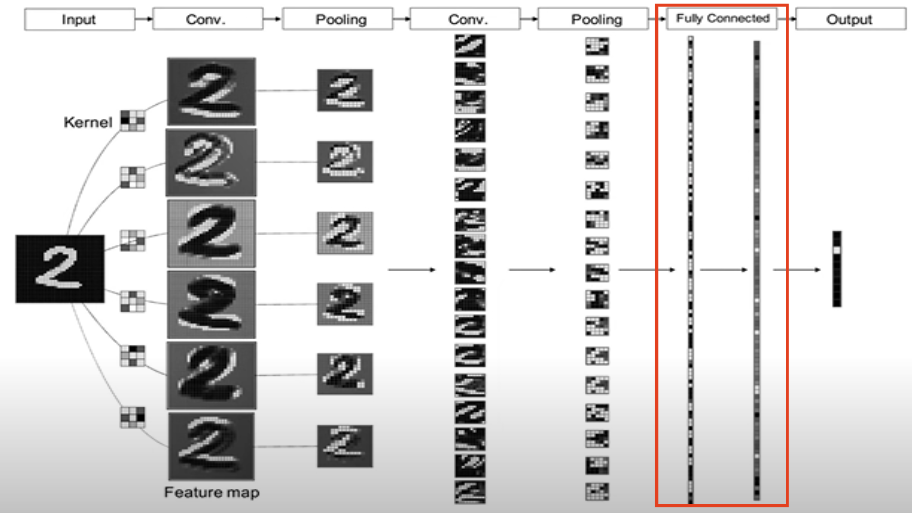

## ✍ 문제1 : 주어진 코드에서 CNN 모델을 구현하시오. 아래 요구사항을 반영하여 빈칸을 완성하시오.

### (요구사항)
1.합성곱 층 (Convolutional Layer)을 두 개 사용

2.첫 번째 합성곱 층의 입력 채널은 1, 출력 채널은 32, 커널 크기는 3, 패딩 1, 스트라이드는 1로 설정하세요.

nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

3.두 번째 합성곱 층의 입력 채널은 32, 출력 채널은 64, 커널 크기는 3, 패딩 1, 스트라이드는 1로 설정하세요.

nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

4.각 합성곱 층 뒤에는 ReLU 활성화 함수와 MaxPooling을 추가합니다.

        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)

        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)

        # 풀링 크기: 2x2, 스트라이드: 2

5.마지막에는 Fully Connected Layer를 추가하여 10개의 클래스를 예측하도록 설정합니다.
        # Final FC 7x7x64 inputs -> 10 outputs

6.가중치 초기화를 설정하세요.

In [5]:
# CNN Model (2 conv layers)
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 첫 번째 합성곱 층
        self.layer1 = torch.nn.Sequential(
            # Conv Layer
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            # Activation Function
            torch.nn.ReLU(),
            # Max Pooling
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두 번째 합성곱 층
        self.layer2 = torch.nn.Sequential(
            # Conv Layer
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # Activation Function
            torch.nn.ReLU(),
            # Max Pooling
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # Fully connected layer
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # 가중치 초기화 (Xavier Initialization)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten for fully connected layer
        out = self.fc(out)
        return out


## ✍ 문제2.초기화
####주어진 CNN 구조에서 ReLU 활성화 함수가 사용되고 있다. weight initialization을 위해 어떤 초기화 기법을 사용했는지 쓰고, 그 이유에 대해 설명해보시오.

answer:weight initialization을 위해 Xavier Initialization 기법을 사용했다. Xavier Initialization는 ReLU 활성화 함수에서 그래디언트 소실/폭발 문제를 방지하는 데 효과적이기 때문이다.

### 6. 모델, 손실 함수 및 옵티마이저 정의

In [6]:
model = CNN()
criterion = torch.nn.CrossEntropyLoss()  # 다중 클래스 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


### 7. 모델 학습

In [7]:
print('Learning started')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(mnist_train) // batch_size

    for i, (batch_xs, batch_ys) in enumerate(data_loader):
        X = Variable(batch_xs)
        Y = Variable(batch_ys)

        # Grad 초기화
        optimizer.zero_grad()

        # 모델 예측
        hypothesis = model(X)

        # 비용 계산
        cost = criterion(hypothesis, Y)

        # 비용을 역전파하여 가중치 업데이트
        cost.backward()
        optimizer.step()

        avg_cost += cost.data / total_batch

    print("[Epoch: {:>4}] cost = {:>.9}".format(epoch + 1, avg_cost))

print('Learning Finished!')


Learning started
[Epoch:    1] cost = 0.186496139
[Epoch:    2] cost = 0.0563218184
[Epoch:    3] cost = 0.0414463878
[Epoch:    4] cost = 0.0326444544
[Epoch:    5] cost = 0.0265179351
[Epoch:    6] cost = 0.0216358509
[Epoch:    7] cost = 0.0175467078
[Epoch:    8] cost = 0.0143866818
[Epoch:    9] cost = 0.0127329128
[Epoch:   10] cost = 0.010104334
Learning Finished!


### 8. 모델 평가 (테스트)

In [8]:
model.eval()
X_test = Variable(mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float())
Y_test = Variable(mnist_test.test_labels)

prediction = model(X_test)
correct_prediction = (torch.max(prediction.data, 1)[1] == Y_test.data)
accuracy = correct_prediction.float().mean()
print('Accuracy:', accuracy)


/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: tensor(0.9855)


### 9. 랜덤 테스트 이미지 예측
테스트 데이터셋에서 임의로 하나의 이미지를 선택하여 예측 진행

Ground Truth: tensor([1])
prediction: tensor([[-6720.4033,  3255.1443, -2173.9292, -2627.9160,   659.9969, -3412.1702,
         -2947.5117,  -745.9965, -1076.7617, -1318.1040]],
       grad_fn=<AddmmBackward0>)
predicted_label: tensor([1])


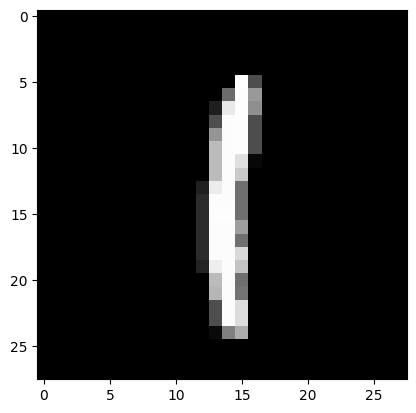

In [9]:
import matplotlib.pyplot as plt
import random

r = random.randint(0, len(mnist_test) - 1)
X_test = Variable(mnist_test.data[r:r+1].view(-1, 1, 28, 28).float())
Y_test = Variable(mnist_test.targets[r:r+1])
print("Ground Truth:", Y_test)
prediction = model(X_test)
predicted_label = (torch.max(prediction.data, 1)[1])
print('prediction:', prediction)
print('predicted_label:', predicted_label)
img = X_test.reshape(28,28).numpy()
plt.imshow(img,cmap='gray')
plt.show()

## **attention 기본 구조 이해하기**
###✍ 문제3: 다음 코드의 빈칸을 채우고 코드를 실행해보세요.


In [10]:
import torch
import torch.nn.functional as F

# attention 구조
def simple_attention(query, key, value):
    # query와 key의 내적
    scores = torch.matmul(query, key.transpose(-2, -1))

    # 이 값을 Softmax를 통과시켜 attention score를 구함
    attention_score = F.softmax(scores, dim=-1)

    # attention score를 value에 곱하여 결과를 도출
    output = torch.matmul(attention_score, value)

    return output, attention_score

# 예시 데이터 (임의의 작은 tensor 사용)
query = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
key = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
value = torch.tensor([[1.0, 2.0], [3.0, 4.0]])

# attention 계산
output, attention_score = simple_attention(query, key, value)

# 결과 출력
print("Attention Scores:")
print(attention_score)
print("\nOutput:")
print(output)

Attention Scores:
tensor([[0.7311, 0.2689],
        [0.2689, 0.7311]])

Output:
tensor([[1.5379, 2.5379],
        [2.4621, 3.4621]])


###✍문제4 : 출력 결과를 해석해보세요.

hint: 몇 번째 query와 몇 번째 key의 유사도는 ____%이다.

answer: Query 1과 Key 1의 유사도는 73.11% 이고 Query 1과 Key 2의 유사도는 26.89% 이다. Query 2와 Key 1의 유사도는 26.89%이고 Query 2와 Key 2의 유사도는 73.11% 이다. Query 1은 Key 1과 더 높은 유사도를 가지며, Query 2는 Key 2와 더 높은 유사도를 가지는 것을 알 수 있다.

## **DNN Optimizer 진행**

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

In [13]:
cancer=datasets.load_breast_cancer()
df=pd.DataFrame(cancer.data,columns=cancer.feature_names)
df['target']=cancer.target
df.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   worst symmetry  worst fractal dimension  target  
0          0.4601                  0.11890       0  
1          0.2750                  0.08902       0  
2          0.3613                  0.08758       0  
3          0.6638                  0.17300       0  
4          0.2364                  0.07678       0  

[5 rows x 31 columns]

In [14]:
from sklearn.preprocessing import StandardScaler
SS=StandardScaler()
cancer_scaled=SS.fit_transform(cancer.data)
input=cancer_scaled
output=df['target']

In [15]:
from sklearn.model_selection import train_test_split
train_input,test_input,train_output,test_output=train_test_split(input,output)

In [16]:
from keras.models import Sequential
from keras.layers import Dense

In [18]:
DNN=Sequential()
DNN.add(Dense(100,activation="relu"))
DNN.add(Dense(1,activation="sigmoid"))
DNN.compile(loss="mean_squared_error", metrics=['accuracy'], optimizer="adam")

In [19]:
DNN.fit(train_input,train_output,epochs=10, batch_size=50)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8158 - loss: 0.1719
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9432 - loss: 0.0919 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9344 - loss: 0.0639 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9621 - loss: 0.0453 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9670 - loss: 0.0365 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9823 - loss: 0.0321 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9867 - loss: 0.0265 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9777 - loss: 0.0270 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9803 - loss: 0.0268 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9785 - loss: 0.0257 


### ✍ 문제5. 위 코드에서 어떤 optimizer를 썼을지 생각하여 optimizer 빈칸을 채우고, 그 빈칸이 나온 이유에 대해 설명해보세요. (ppt에서 배운 optimizer들 최대한 하나씩 넣어서 진행해보고 최적의 optimizer에 대한 근거를 설명해보시오)

hint : adam이 안나왔을 경우, epoch나 batch size 등을 조절해보세요

answer: adam은 각 가중치마다 학습률을 자동으로 조정하여 효율적으로 학습한다.확률적 경사 하강법보다 빠르게 수렴하며 학습 과정이 더 안정적이다. 또한 이전 기울기 정보와 학습률 조정 기법을 결합하여 최적의 방향으로 효과적인 학습을 진행한다.